# Exploratory Data Analysis: Solar Wind & Kp Index
This notebook performs EDA on the Aurora project data pipeline.

**Goal:** Understand the distribution, missing values, and correlations of Solar Wind (OMNI) features before training the model.

In [3]:
# Standard Data Science Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Project Specific Imports
import logging
from pathlib import Path
from src.data import (
    fetch_omni_data,
    fetch_kp_range,
    clean_solarwind,
    add_time_features,
    add_moving_averages
)

# Configuration
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid') # Or 'ggplot'
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# 1. Load & Merge Data

In [42]:
# Parameters (matching default args in build_dataset.py)
START_YEAR = 2010
END_YEAR = 2011

logging.info(f"Fetching historical data from {START_YEAR} to {END_YEAR}...")

# 1. Fetch Solar Wind Data (OMNI)
try:
    sw_df = fetch_omni_data(start_year=START_YEAR, end_year=END_YEAR)
    logging.info(f"Solar Wind Data shape: {sw_df.shape}")
except Exception as e:
    logging.error(f"Error fetching OMNI data: {e}")
    # Fallback if fetch fails (e.g., load from cache if you have one)
    # sw_df = pd.read_pickle("data/interim/omni_cached.pkl")

# 2. Fetch Kp Index
try:
    kp_df = fetch_kp_range(start_year=START_YEAR, end_year=END_YEAR)
    logging.info(f"Kp Data shape: {kp_df.shape}")
except Exception as e:
    logging.error(f"Error fetching Kp data: {e}")

# 3. Merge (Simple time-based merge assumption, adjust based on actual src.data logic)
# Assuming indices are datetime objects
df = pd.merge(sw_df, kp_df, left_index=True, right_index=True, how='inner')
logging.info(f"Merged Data shape: {df.shape}")

df.head()

2026-01-05 15:37:28,595 - INFO - Fetching historical data from 2010 to 2011...
2026-01-05 15:37:28,596 - INFO - Fetching OMNI 1-min data 2010-2011...
/Users/shaanpatel/Desktop/AuroraNet/src/data/fetch_sw_historical.py:35: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['time_tag'] = df['time_tag'].dt.round('S')  # Round to nearest second
2026-01-05 15:37:29,127 - INFO - Solar Wind Data shape: (1051200, 6)
2026-01-05 15:37:29,139 - INFO - Kp Data shape: (5840, 2)
2026-01-05 15:37:29,141 - INFO - Merged Data shape: (5840, 8)


Loading Kp for 2010 ...
Loading Kp for 2011 ...


,time_tag_x,speed,density,b,bz,temp,time_tag_y,kp_index
0,2010-01-01 00:00:00,283.200012,3.85,3.00,0.38,24931.0,2010-01-01 00:00:00,1.0
1,2010-01-01 00:24:00,283.200012,3.85,3.01,0.26,24931.0,2010-01-01 03:00:00,0.0
2,2010-01-01 00:48:00,283.899994,3.92,3.02,0.40,24931.0,2010-01-01 06:00:00,0.0
3,2010-01-01 01:12:00,283.899994,3.92,3.02,0.54,24931.0,2010-01-01 09:00:00,0.0
4,2010-01-01 01:36:00,283.799988,4.02,3.03,0.32,25005.0,2010-01-01 12:00:00,0.0


# 2. Data Overview & Missing Values
Look at the raw data quality before cleaning.

In [43]:
print("Data Info:")
print(df.info())

print("\nSummary Statistics:")
display(df.describe())

Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5840 entries, 0 to 5839
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time_tag_x  5840 non-null   datetime64[ns]
 1   speed       4637 non-null   float32       
 2   density     4637 non-null   float32       
 3   b           5613 non-null   float32       
 4   bz          5613 non-null   float32       
 5   temp        4637 non-null   float32       
 6   time_tag_y  5840 non-null   datetime64[ns]
 7   kp_index    5840 non-null   float64       
dtypes: datetime64[ns](2), float32(5), float64(1)
memory usage: 296.6 KB
None

Summary Statistics:


,time_tag_x,speed,density,b,bz,temp,time_tag_y,kp_index
count,5840,4637.000000,4637.000000,5613.000000,5613.000000,4637.000000,5840,5840.000000
mean,2010-01-14 08:53:45.205479424,288.121368,8.350494,5.541395,1.247394,35782.761719,2010-12-31 22:29:59.999999744,1.389041
min,2010-01-01 00:00:00,257.899994,2.950000,1.320000,-6.940000,7107.000000,2010-01-01 00:00:00,-1.000000
25%,2010-01-08 05:54:00,281.100006,5.750000,4.180000,-0.510000,19646.000000,2010-07-02 11:15:00,1.000000
50%,2010-01-14 07:48:00,288.399994,7.550000,5.850000,1.220000,28122.000000,2010-12-31 22:30:00,1.000000
75%,2010-01-20 09:42:00,295.500000,10.780000,6.840000,3.250000,45251.000000,2011-07-02 09:45:00,2.000000
max,2010-01-27 23:36:00,326.899994,20.809999,9.170000,7.500000,151371.000000,2011-12-31 21:00:00,8.000000
std,NaN,10.723483,3.550748,1.527380,2.990184,23438.148438,NaN,1.183759


/Users/shaanpatel/Desktop/AuroraNet/aurora-env/lib/python3.9/site-packages/missingno/missingno.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_array = pd.date_range(df.index[0], df.index[-1],
/Users/shaanpatel/Desktop/AuroraNet/aurora-env/lib/python3.9/site-packages/missingno/missingno.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_ticks = pd.date_range(df.index[0], df.index[-1],


<Figure size 1500x600 with 0 Axes>

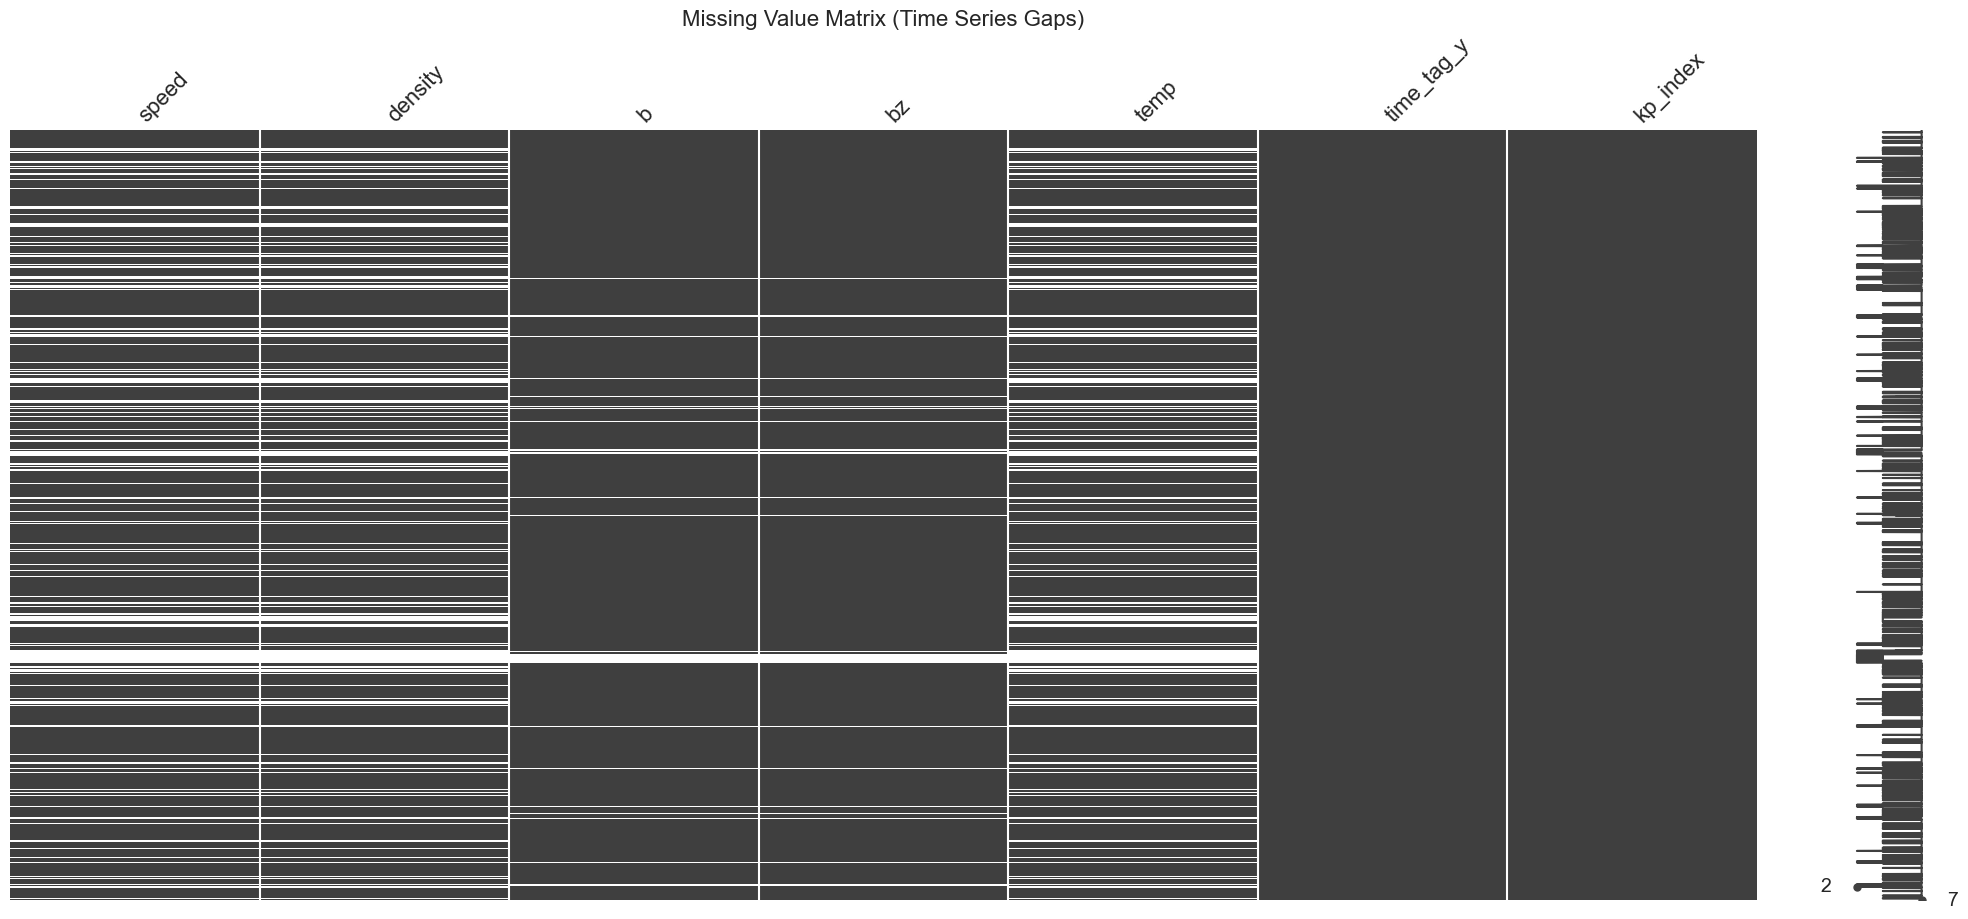

/var/folders/v7/_693nzgx4rl_8f0kw0jg8k980000gn/T/ipykernel_66982/560154306.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')


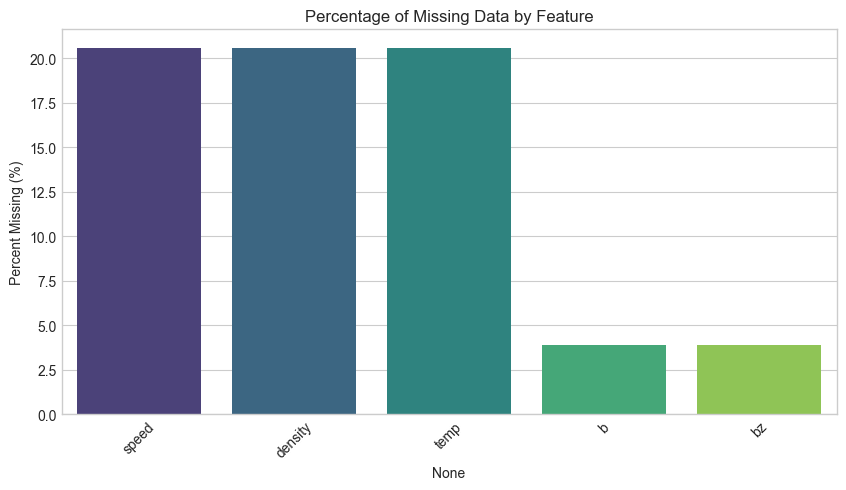

In [27]:
# Using missingno to visualize gaps in the time series
df = df.set_index('time_tag_x')
plt.figure(figsize=(15, 6))
msno.matrix(df, freq='M') # 'M' resamples to Month for readability if data is high-res
plt.title("Missing Value Matrix (Time Series Gaps)", fontsize=16)
plt.show()

# Percentage of missing values per column
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

if not missing_percent.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')
    plt.title("Percentage of Missing Data by Feature")
    plt.ylabel("Percent Missing (%)")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No missing values found (or already handled in fetch step).")

             time_tag       speed  density     b    bz     temp  kp_index
0 2010-01-01 00:00:00  283.200012     3.85  3.00  0.38  24931.0       1.0
1 2010-01-01 00:24:00  283.200012     3.85  3.01  0.26  24931.0       1.0
2 2010-01-01 00:48:00  283.899994     3.92  3.02  0.40  24931.0       1.0
3 2010-01-01 01:12:00  283.899994     3.92  3.02  0.54  24931.0       1.0
4 2010-01-01 01:36:00  283.799988     4.02  3.03  0.32  25005.0       1.0


/Users/shaanpatel/Desktop/AuroraNet/aurora-env/lib/python3.9/site-packages/missingno/missingno.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_array = pd.date_range(df.index[0], df.index[-1],
/Users/shaanpatel/Desktop/AuroraNet/aurora-env/lib/python3.9/site-packages/missingno/missingno.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_ticks = pd.date_range(df.index[0], df.index[-1],


<Figure size 1500x600 with 0 Axes>

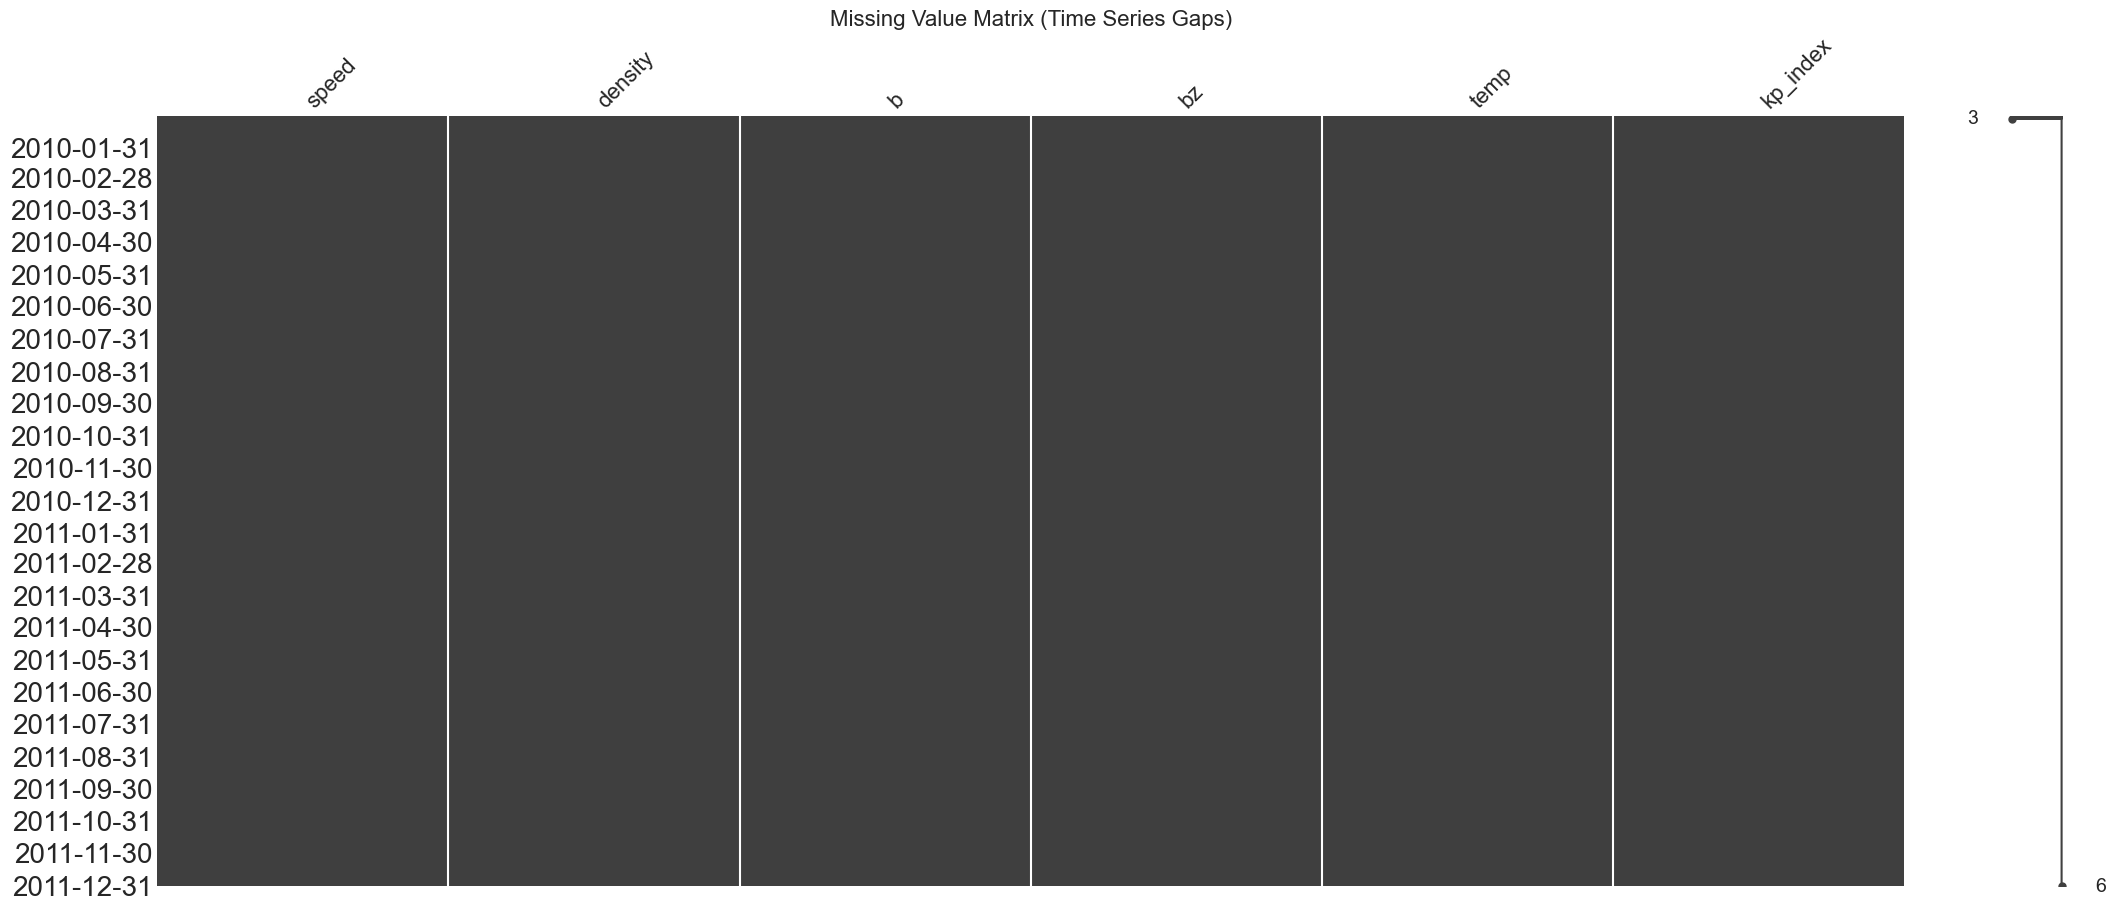

/var/folders/v7/_693nzgx4rl_8f0kw0jg8k980000gn/T/ipykernel_66982/1134704849.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')


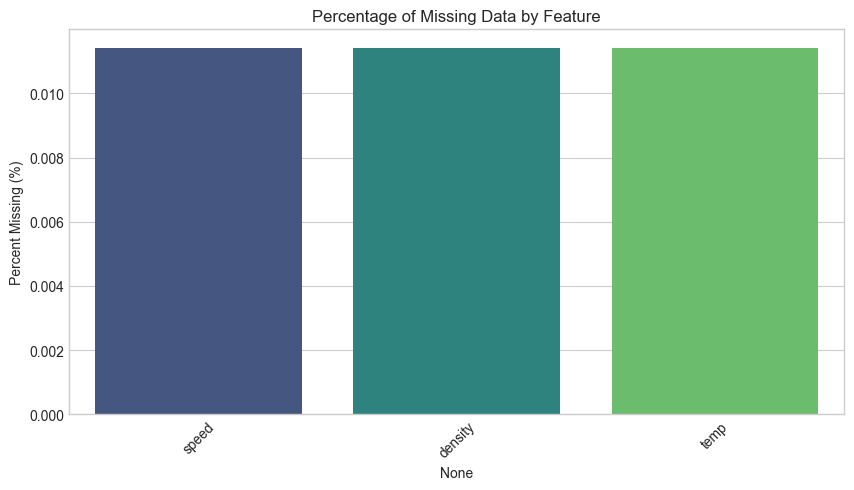

In [55]:
sw_df = sw_df.groupby('time_tag').mean().reset_index()
kp_df = kp_df.groupby('time_tag').mean().reset_index()
kp_df = kp_df.set_index('time_tag').resample('1min').ffill()
df = pd.merge(sw_df, kp_df, on='time_tag', how='inner')
print(df.head())

df = df.set_index('time_tag')
plt.figure(figsize=(15, 6))
msno.matrix(df, freq='M') # 'M' resamples to Month for readability if data is high-res
plt.title("Missing Value Matrix (Time Series Gaps)", fontsize=16)
plt.show()

# Percentage of missing values per column
missing_percent = df.isnull().mean() * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)

if not missing_percent.empty:
    plt.figure(figsize=(10, 5))
    sns.barplot(x=missing_percent.index, y=missing_percent.values, palette='viridis')
    plt.title("Percentage of Missing Data by Feature")
    plt.ylabel("Percent Missing (%)")
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No missing values found (or already handled in fetch step).")

# 3. Distributions & Outliers
Checking the distribution of key physical parameters (e.g., `bz`, `speed`, `density`).

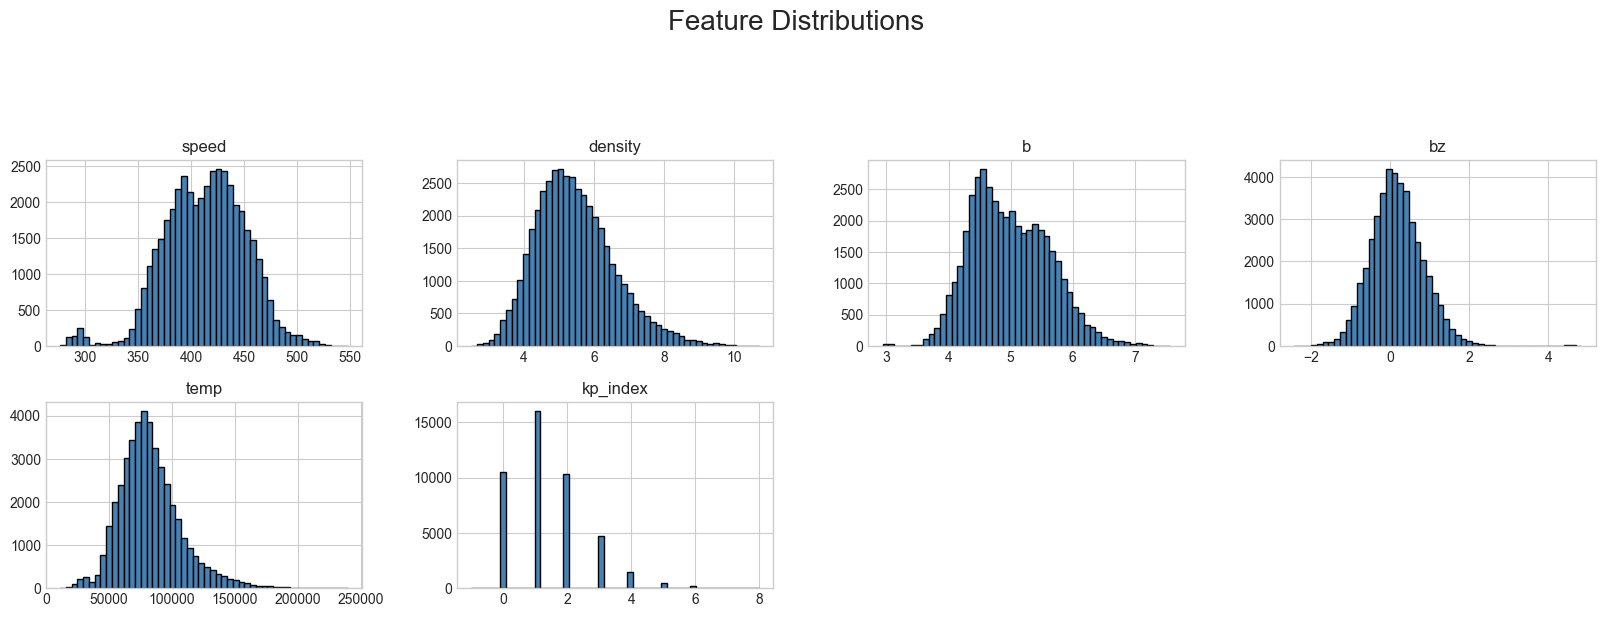

In [56]:
# Identify numerical columns (excluding Kp usually, which is ordinal/discrete-like)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Plot histograms
df[num_cols].hist(bins=50, figsize=(20, 15), layout=(5, 4), color='steelblue', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=20)
plt.show()

# 4. Feature Engineering
We apply the pipeline steps `clean_solarwind`, `add_time_features`, and `add_moving_averages` to see how features change.

In [58]:
# 1. Clean
df = df.reset_index() # Made time_tag index for previous plot, reset so not dropped in next step
df_clean = clean_solarwind(df)
# 2. Add Time Features (Cyclical)
df_features = add_time_features(df_clean)

# 3. Add Moving Averages 
ma_cols = ['speed', 'density', 'bz', 'b']
df_final = add_moving_averages(df_features, columns=ma_cols)

print(f"Shape after feature engineering: {df_final.shape}")
df_final.head()

Shape after feature engineering: (43793, 19)


/Users/shaanpatel/Desktop/AuroraNet/src/data/preprocess.py:30: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


,index,time_tag,speed,density,b,bz,temp,kp_index,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,year,speed_ma3,density_ma3,bz_ma3,b_ma3
0,0,2010-01-01 00:00:00,283.200012,3.85,3.00,0.38,24931.0,1.0,0.000000,1.000000,0.017213,0.999852,0.5,0.866025,10,283.200012,3.850000,0.380000,3.000000
1,1,2010-01-01 00:24:00,283.200012,3.85,3.01,0.26,24931.0,1.0,0.000000,1.000000,0.017213,0.999852,0.5,0.866025,10,283.200012,3.850000,0.320000,3.005000
2,2,2010-01-01 00:48:00,283.899994,3.92,3.02,0.40,24931.0,1.0,0.000000,1.000000,0.017213,0.999852,0.5,0.866025,10,283.433339,3.873333,0.346667,3.010000
3,3,2010-01-01 01:12:00,283.899994,3.92,3.02,0.54,24931.0,1.0,0.258819,0.965926,0.017213,0.999852,0.5,0.866025,10,283.666667,3.896667,0.400000,3.016667
4,4,2010-01-01 01:36:00,283.799988,4.02,3.03,0.32,25005.0,1.0,0.258819,0.965926,0.017213,0.999852,0.5,0.866025,10,283.866659,3.953333,0.420000,3.023333


# 5. Correlation Analysis
We look at how features correlate with the target (`kp_index`).

/var/folders/v7/_693nzgx4rl_8f0kw0jg8k980000gn/T/ipykernel_66982/4135224835.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='coolwarm')


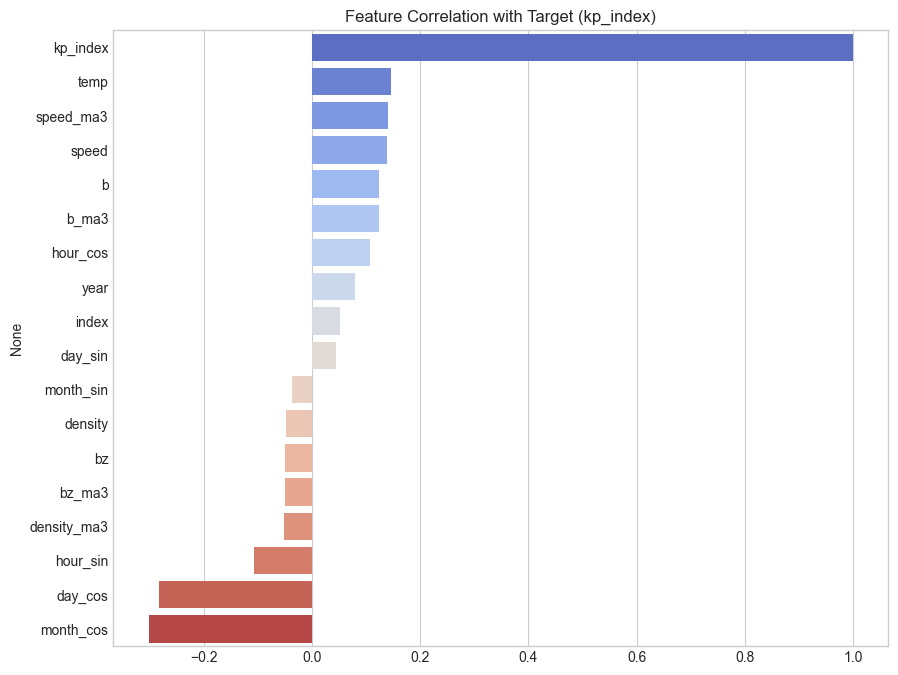

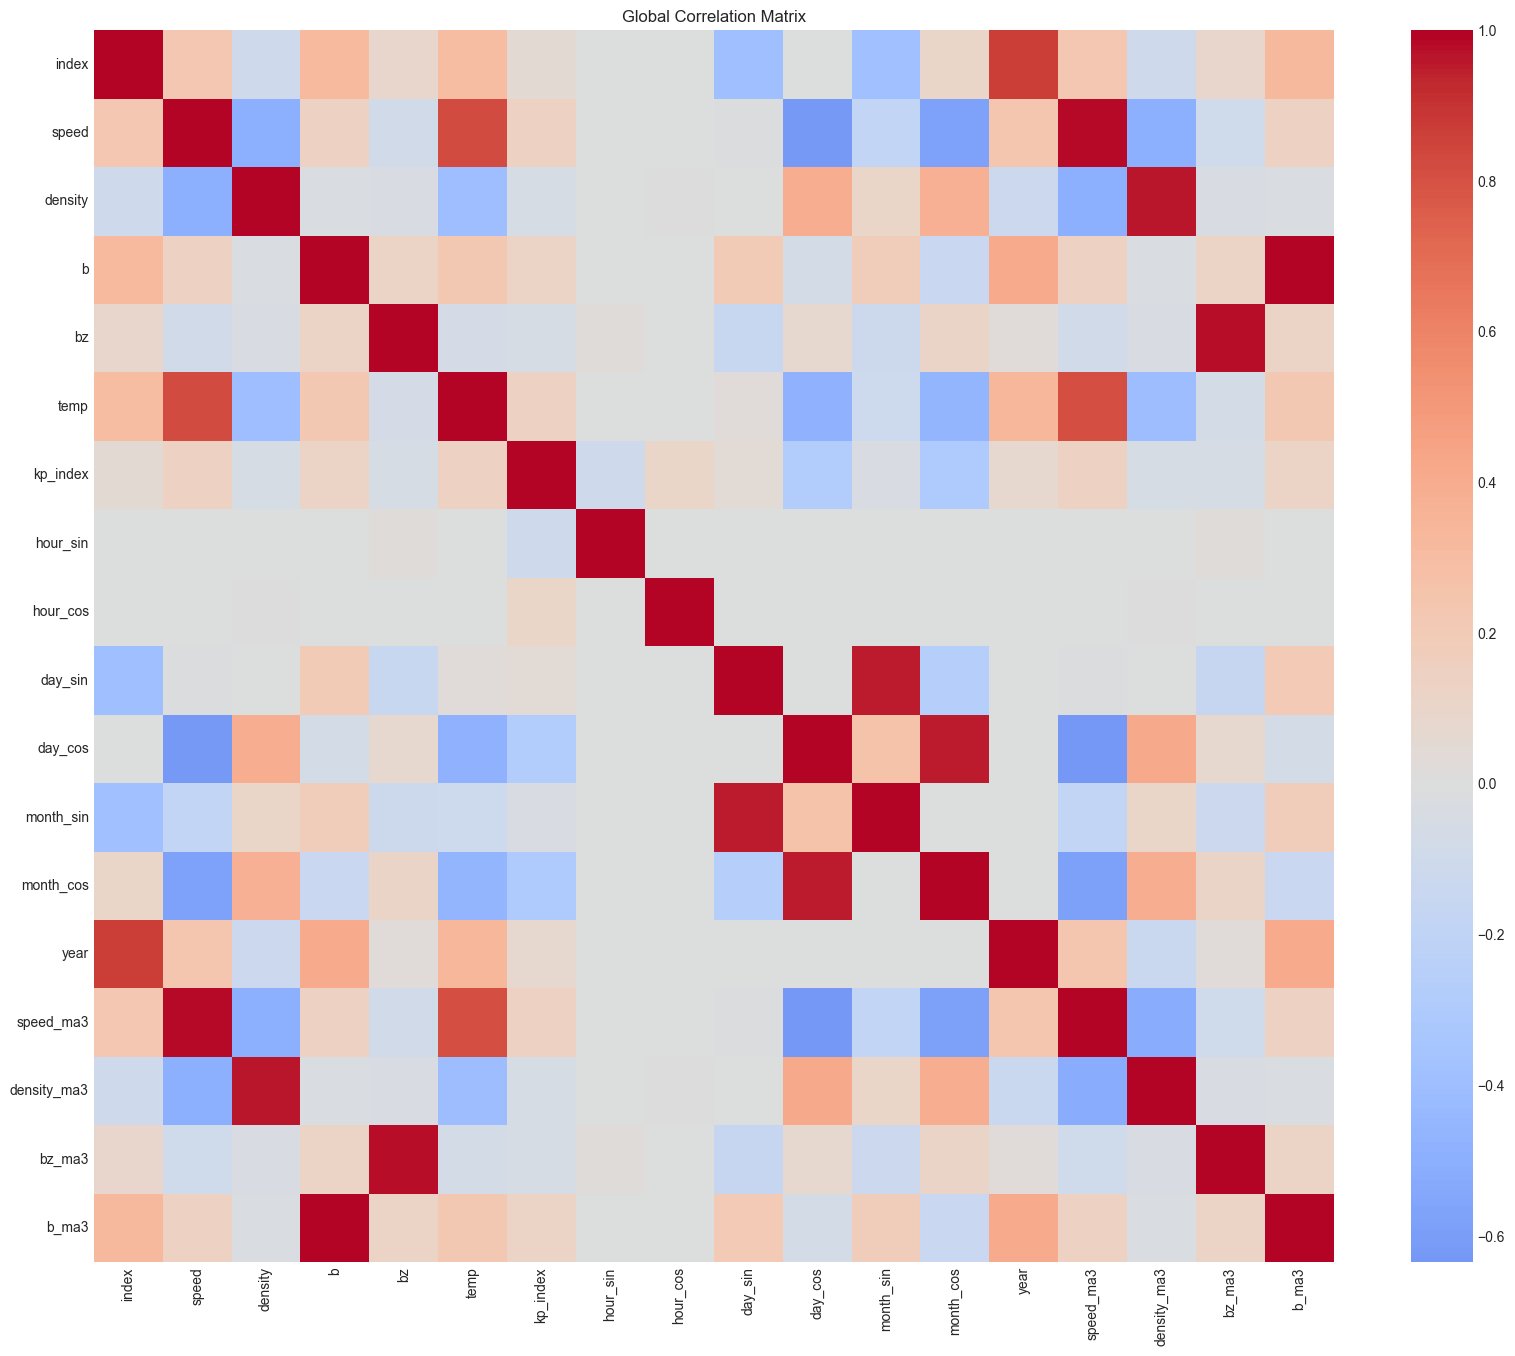


Variance Inflation Factor (Top Correlated Features):


,Feature,VIF
2,speed,5251.052711
1,speed_ma3,5125.116077
4,b_ma3,4347.515064
3,b,4265.177970
6,year,500.280371
13,density_ma3,349.010086
10,density,319.519432
0,temp,39.290678
12,bz_ma3,24.656957
11,bz,24.505879


In [62]:
def analyze_correlations(df, target_col='kp_index'):
    # Select numerical columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    # 1. Correlation with Target
    corr_with_target = numeric_df.corrwith(numeric_df[target_col]).sort_values(ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='coolwarm')
    plt.title(f"Feature Correlation with Target ({target_col})")
    plt.show()

    # 2. Full Heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm', center=0)
    plt.title("Global Correlation Matrix")
    plt.show()

    # 3. VIF (Variance Inflation Factor) check for Multicollinearity
    # (Handling infinite values or NaNs first if present)
    clean_num = numeric_df.dropna().replace([np.inf, -np.inf], np.nan).dropna()
    
    # Selecting a subset if too many columns (e.g., top 15 correlated)
    top_cols = corr_with_target.head(15).index.tolist()
    X = clean_num[top_cols].drop(columns=[target_col], errors='ignore')
    
    vif_data = pd.DataFrame()
    vif_data['Feature'] = X.columns
    vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    
    print("\nVariance Inflation Factor (Top Correlated Features):")
    display(vif_data.sort_values(by='VIF', ascending=False))

analyze_correlations(df_final, target_col='kp_index')

# 6. Time Series Visualization
For Aurora data we need to visualize the time series, specifically identifying storm events (high Kp).

Empty DataFrame
Columns: [index, time_tag, speed, density, b, bz, temp, kp_index, hour_sin, hour_cos, day_sin, day_cos, month_sin, month_cos, year, speed_ma3, density_ma3, bz_ma3, b_ma3]
Index: []


KeyError: 'x'

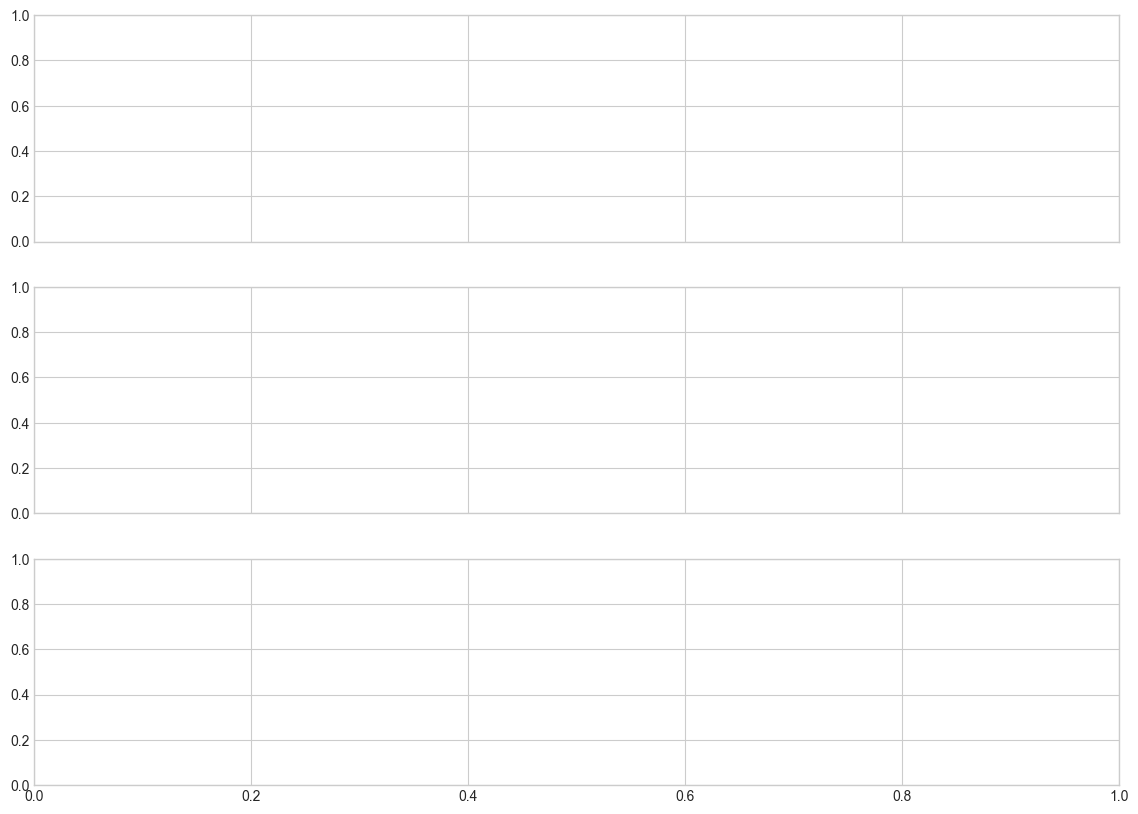

In [ ]:
def plot_storm_event(df, start_date, end_date):
    """Plots Solar Wind parameters and Kp index for a specific date range."""
    subset = df.loc[
    (df['time_tag'] >= start_date) &
    (df['time_tag'] <= end_date)
]
    print(subset.head())
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 10), sharex=True)
    
    # Plot Kp
    if 'kp_index' in subset.columns:
        sns.lineplot(data=subset, x=subset.index, y='kp_index', ax=axes[0], color='red', linewidth=2)
        axes[0].set_ylabel("Kp Index")
        axes[0].set_title(f"Geomagnetic Storm Event: {start_date} to {end_date}")
        axes[0].axhline(y=5, color='black', linestyle='--', label='Storm Threshold')
        axes[0].legend()

    # Plot Bz (Interplanetary Magnetic Field) - Critical for storms
    # Adjust column name 'bz' based on your actual data schema
    bz_col = [c for c in subset.columns if 'bz' in c.lower()]
    if bz_col:
        sns.lineplot(data=subset, x=subset.index, y=bz_col[0], ax=axes[1], color='blue')
        axes[1].set_ylabel("Bz (nT)")
        axes[1].axhline(y=0, color='gray', linestyle='--', linewidth=0.5)

    # Plot Speed/Density
    # Adjust column names 'speed', 'density' based on schema
    speed_col = [c for c in subset.columns if 'speed' in c.lower()]
    if speed_col:
        sns.lineplot(data=subset, x=subset.index, y=speed_col[0], ax=axes[2], color='green')
        axes[2].set_ylabel("Solar Wind Speed (km/s)")

    plt.tight_layout()
    plt.show()

# Example: St. Patrick's Day Storm 2015
plot_storm_event(df_final, '2015-03-15', '2015-03-20')